<IPython.core.display.Javascript object>


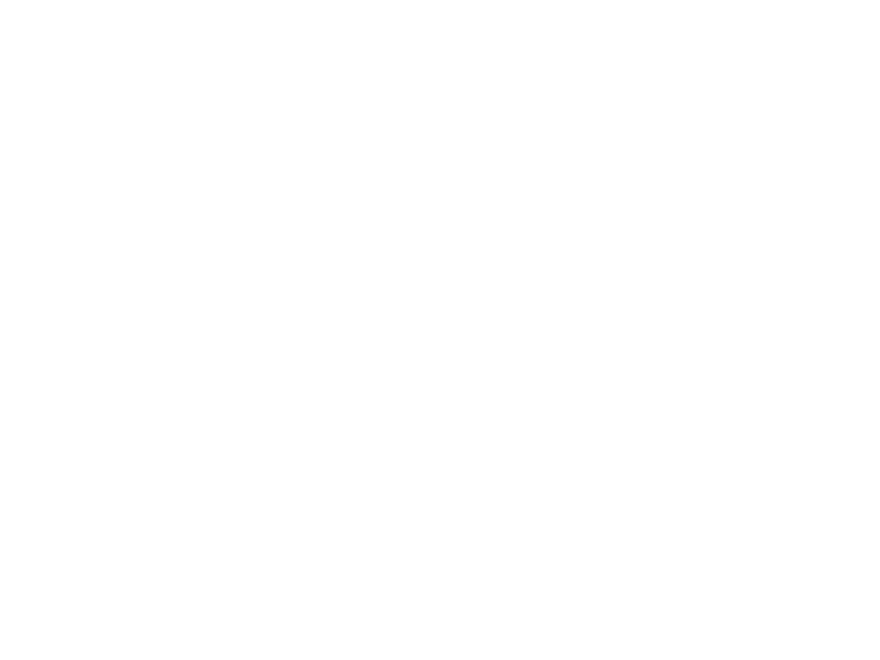

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [241]:
import cv2        
import numpy as np
import math 
import time      #importing libraries

def click_event(event, x, y, flags, params): #getting coordinates of mouse on the displayed window when 
                                             #when we press left button on mouse
    global cx,cy,start
    if event == cv2.EVENT_LBUTTONDOWN:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,'.', (x,y), font,
        1, (0, 0, 255), 8)
        cv2.imshow('frame', frame)
        start=time.time()
        cx=x
        cy=y


import matplotlib.pyplot as plt  # library for plotting data

yi=[] #list to store amplitude
xi=[] #list to store time values   

%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

fig = plt.figure()      # creating figure for plotting 
ax = fig.add_subplot(111) 
fig.show()
 
font = cv2.FONT_HERSHEY_SIMPLEX 
cap = cv2.VideoCapture(1) #reading live feed form camera

cx=0  # x coordinate of joint  
cy=0  # y coordinate of joint
cpx=0 # x coordinate of pendulum bob
cpy=0 # y coordinate of pendulum bob
l=26  # lenght of pendulum
start = time.time() #recording start time

 
while(1):
    _, frame = cap.read()
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) #converting to hsv

    lower = np.array([22, 93, 0])
    upper = np.array([45, 255, 255]) #mask values for specific color detection here light green
    
    mask = cv2.inRange(hsv, lower, upper) #creating mask

    result = cv2.bitwise_and(frame, frame, mask = mask) #resulting image after mask

    
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #finding contours around specific colors 
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if (cv2.contourArea(c)) > 60: #drawing contours if area os greater than threshold
            cv2.rectangle(frame, (x, y), (x + w, y + h), (36,255,12), 2)
            cpx=x+w/2 # x coordinate of pendulum bob
            cpy=y+h/2 # y coordinate of pendulum bob

    
    cv2.imshow('frame', frame) #showing frame 
    cv2.setMouseCallback('frame', click_event) # clicking mouse 
    cv2.imshow('result', result)  # shows resultant image
    if cx!=0 and cy!=0: #detection of pendulum coordinates will start after clicking 
        if (cpx-cx)!=0:
            angler=math.pi/2-math.atan((cpx-cx)/(cpy-cy))
        else:
            angler=0
        angle=angler*180/math.pi #finding angle 
        dx=l*math.sin(angler)
        dy=l*math.cos(angler)
        t=time.time()-start #recording time
       # ax.set_xlim(left=max(0, t-20), right=t+20)
        xi.append(t)
        yi.append(dy)

        fig.canvas.draw()

        ax.plot(xi,yi,"b") #updating plot
    
    if cv2.waitKey(40) == 27:
        break

cv2.destroyAllWindows()
cap.release()

In [23]:
def time(data,time):
    x=0
    for i in range(len(data)):
        if data[i]>0:
            if data[i]>data[i-1] and data[i]>data[i+1]: #detecting peak values
                x=x+1
    return((x+2)/(time[-1]-time[0])) #no.of cycles by total time
    

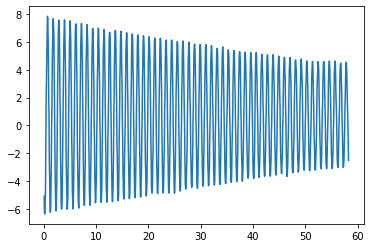

In [21]:
plt.plot(xi,yi) #ploting amplitude vs time

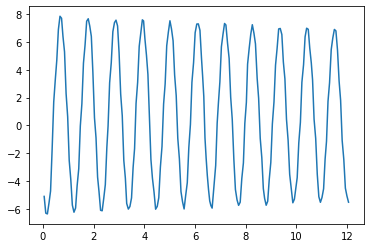

In [131]:
plt.plot(xi[0:200],yi[0:200]) #zooming into the plot

In [132]:
time(yi,xi)  #finding time period

0.962312877452296

In [3]:
import pandas as pd
df = pd.DataFrame(yi,xi) #creating pandas data set
df.to_csv('pendulum2.csv') #saving data in csv file

In [5]:
import csv
xi=[]
yi=[]

with open('pendulum2.csv', newline='') as f:
    reader = csv.reader(f) 
    data = list(reader) #reading csv file 

for i in range(1,len(data)):
    xi.append(float(data[i][0])) #getting time values from csv file
    yi.append(float(data[i][1])) #getting amplitude values from csv file 
    

In [8]:
def peakfinder(data,xi): #function to find peak values
    outy=[]
    outx=[]
    for i in range(len(data)):
        if data[i]>0:
            if data[i+1]<data[i] and data[i-1]<data[i]: #find peaks
                outy.append(data[i])
                outx.append(xi[i])
    return(outy,outx)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def model(t,b):
    global yi
    a=max(yi)
    return a*np.exp(b*t) # model to fit exponential part of the function

def fitdata(xi,data): #function to fit data and returns damping factor

    y=data
    x = xi

    # do the fit with some initial values
    popt, pcov = curve_fit(model, x , y )

    b=popt

    # prepare some data for a plot
    xx = np.linspace(0,60)
    yy = model(xx,b)

    plt.plot(x,y,'o',xx, yy)
    plt.title('Exponential Fit')

    plt.show()
    return(b[0])

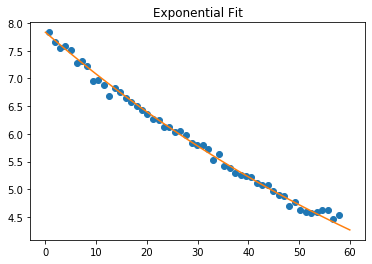

-0.010118723042644115


In [111]:
beta=fitdata(peakfinder(yi,xi)[1],peakfinder(yi,xi)[0]) #finding damping factor
print(beta)

In [176]:
def final(t,a,b,w,p):
    return (a)*np.exp(b*t)*np.sin(w*t+p) #final amplitude function to plot fitted model


In [133]:
def model2(t,a,c):
    global yi
    return (max(yi))*np.exp(beta*t)*np.sin((2*np.pi/a)*t+c) #model to find time period and phase

def fitdata2(xi,data): #fitting 

    y=data
    x = xi

    # do the fit with some initial values
    popt, pcov = curve_fit(model2, x , y )

    a,c=popt

    # prepare some data for a plot
    xx = np.array(xi)
    yy = model2(xx,a,c)+0.5

    plt.plot(x[20:80],y[20:80],'o',xx[20:80], yy[20:80])
    plt.title('Exponential Fit')

    plt.show()
    return(float(a),float(c))

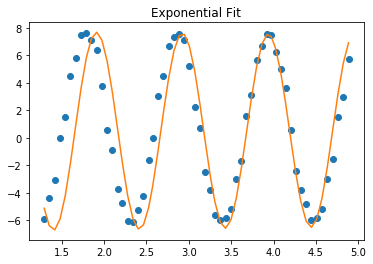

Time period:
1.0137332697333548
Phase:
2.305398432568703


In [127]:
timeperiod,phase=fitdata2(xi,yi)
print("Time period:")
print(timeperiod)
print("Phase:")
print(phase)

#zoomed version of actual plot and fitted model 

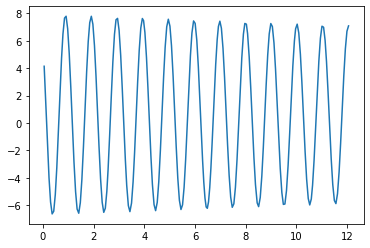

In [136]:
xx = np.array(xi)
yy = final(xx,max(yi),beta,2*np.pi/timeperiod,phase)+0.6 #evaluvating final function over range of time values

plt.plot(xx[0:200], yy[0:200]) #ploting actualdata and fitted model.

In [72]:
def phasetrajectory(m,p,c):
    return ((E-a*p**2)/b)**0.5
    

In [177]:
def momentum(t,a,b,c,d):
    w=2*np.pi/c
    return(a*np.exp(b*t)*(b*np.cos(w*t+d)-w*np.sin(w*t+d)))

In [134]:
print("amplitude:")
print(max(yi))
print("Damping factor:")
print(beta)
print("Timeperiod:")
print(timeperiod)
print("phase:")
print(phase)




amplitude:
7.83295206028578
Damping factor:
-0.010118723042644115
Timeperiod:
1.0137332697333548
phase:
2.305398432568703


In [185]:
pi=[]
pxi=[]

for i in range(1,1000):
    a=max(yi)
    b=beta
    w=2*np.pi/timeperiod
    p=phase
    pxi.append(final(i,a,b,w,p))
    pi.append(momentum(i,a,b,timeperiod,p))
    

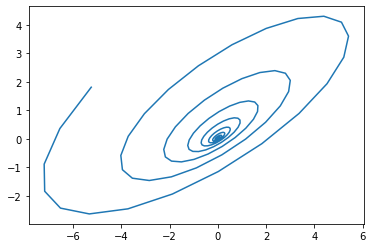

In [240]:
r = a
w = 2*np.pi/timeperiod
t = np.linspace(0,1000,360)
x = r*np.exp(beta*t)*np.cos(w*np.radians(t)+phase)
p = m*r*np.exp(beta*t)*(b*np.cos(w*np.radians(t)+phase)-w*np.sin(w*np.radians(t))+phase)
plt.plot(x,p)